In [1]:
from os import path, listdir
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# fix cudaNN issue in docker
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5



In [7]:
DATA_DIR = "./datasets/sounds-25ms"
CLASSES = ["clap", "click", "q", "talking"]

(IMG_WIDTH, IMG_HEIGHT) = (18, 128)

In [8]:
def get_training_data():
    training_data = []
    for i in range(len(CLASSES)):
        data_class = CLASSES[i]
        directory = path.join(DATA_DIR, data_class)
        for img_path in listdir(directory):
            try:
                img_array = cv2.imread(
                    path.join(directory, img_path), cv2.IMREAD_GRAYSCALE
                )
                # probably wont be needed in sound since all clips should be exact same size
                img_array = cv2.resize(img_array, (IMG_WIDTH, IMG_HEIGHT))
                training_data.append([img_array, i])
            except Exception as e:
                # print("error")
                pass

    from random import shuffle

    shuffle(training_data)

    x = []
    y = []

    for features, label in training_data:
        x.append(features)
        y.append(label)
    
    return (x, y)


In [9]:
(train_x, train_y) = get_training_data()
print(f"Loaded training data: {len(train_x)}")

Loaded training data: 397


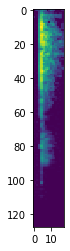

In [15]:
plt.imshow(train_x[0])
plt.show()

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(64, (3,3), input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))

model.add(Dense(len(CLASSES)))
model.add(Activation("softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [32]:
train_x_np = np.array(train_x).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)/255.0
train_y_np = np.array(train_y)
model.fit(train_x_np, train_y_np, epochs=20)

Train on 397 samples
Epoch 1/20
397/397 [==============================] - 0s 876us/sample - loss: 0.9195 - accuracy: 0.6625
Epoch 2/20
397/397 [==============================] - 0s 259us/sample - loss: 0.2976 - accuracy: 0.9219
Epoch 3/20
397/397 [==============================] - 0s 247us/sample - loss: 0.1971 - accuracy: 0.9421
Epoch 4/20
397/397 [==============================] - 0s 242us/sample - loss: 0.1575 - accuracy: 0.9471
Epoch 5/20
397/397 [==============================] - 0s 264us/sample - loss: 0.1148 - accuracy: 0.9622
Epoch 6/20
397/397 [==============================] - 0s 244us/sample - loss: 0.0986 - accuracy: 0.9748
Epoch 7/20
397/397 [==============================] - 0s 237us/sample - loss: 0.0773 - accuracy: 0.9698
Epoch 8/20
397/397 [==============================] - 0s 260us/sample - loss: 0.0862 - accuracy: 0.9698
Epoch 9/20
397/397 [==============================] - 0s 253us/sample - loss: 0.0524 - accuracy: 0.9849
Epoch 10/20
397/397 [======================

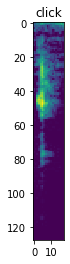

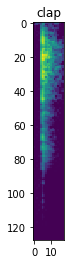

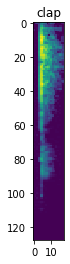

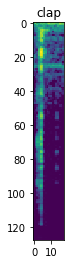

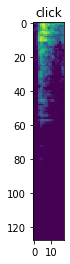

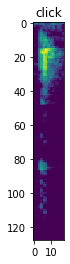

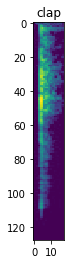

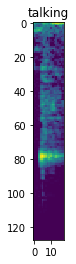

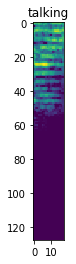

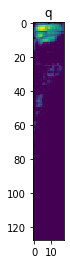

In [34]:
predictions = model.predict(train_x_np[0:10])
for i in range(10):
    img = train_x[i]
    pred = CLASSES[np.argmax(predictions[i])]
    plt.title(pred)
    plt.imshow(img)
    plt.show()

In [53]:
model.save("./v0.h5")

In [43]:
def get_image(path):
    img_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_array = cv2.resize(img_array, (IMG_WIDTH, IMG_HEIGHT))
    return img_array

In [49]:
test_img = get_image("./example3.jpg")
test_img_np = test_img.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)/255.0
print(test_img)

[[ 0 12 17 ...  0  7  0]
 [ 0  2  5 ... 34 12 20]
 [ 0  0  1 ... 52 40 30]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


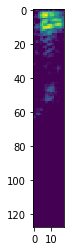

In [50]:
plt.imshow(test_img)
plt.show()

In [51]:
pred = model.predict([test_img_np])
print(CLASSES[np.argmax(pred[0])])

q
